# **Step 1: Import Library**

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# **Step 2: Load Dataset**

In [28]:
df = pd.read_csv("../data/Books_rating.csv.zip", compression="zip")

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [29]:
df.info()

print(f"Null rows:\n{df.isnull().sum()}")

print(f"Duplicated rows: {df.duplicated().sum()}")

print(f"Describe:\n{df.describe()}")

print(f"Number of unique users: {df["User_id"].nunique()}")
print(f"Number of unique books: {df["Id"].nunique()}")
print(f"Number of unique ratings: {df["review/score"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
Null rows:
Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64
Duplicated rows: 8774
Describe:
               Price  review/score   review/time
count  481171.000000  

# **Step 3: Data Preprocessing**

## ***Filtering***

In [30]:
df_filter = df.rename(columns={"User_id": "UserID", "Id": "BookID", "review/score": "Rating"})

df_filter = df_filter[["BookID", "UserID", "Rating"]].dropna().drop_duplicates()

min_reviews = 30
max_reviews = 500

user_counts = df_filter["UserID"].value_counts()

df_filter = df_filter[df_filter["UserID"].map(user_counts).between(min_reviews, max_reviews)]

df_filter.head()

,BookID,UserID,Rating
1,0826414346,A30TK6U7DNS82R,5.0
3,0826414346,A2MVUWT453QH61,4.0
5,0826414346,A2F6NONFUDB6UK,4.0
61,0854968350,ATDE9JYCPI0L1,2.0
140,0789480662,A281NPSIMI1C2R,5.0


In [31]:
df_filter.info()

print(f"Null rows:\n{df_filter.isnull().sum()}")

print(f"Duplicated rows: {df_filter.duplicated().sum()}")

print(f"Describe:\n{df_filter.describe()}")

print(f"Number of unique users: {df_filter["UserID"].nunique()}")
print(f"Number of unique books: {df_filter["BookID"].nunique()}")
print(f"Number of unique ratings: {df_filter["Rating"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Index: 381959 entries, 1 to 2999996
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   BookID  381959 non-null  object 
 1   UserID  381959 non-null  object 
 2   Rating  381959 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.7+ MB
Null rows:
BookID    0
UserID    0
Rating    0
dtype: int64
Duplicated rows: 0
Describe:
              Rating
count  381959.000000
mean        4.249071
std         0.993688
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Number of unique users: 5265
Number of unique books: 82204
Number of unique ratings: 5


In [32]:
user_review_counts = df_filter["UserID"].value_counts()
user_review_counts_df = user_review_counts.reset_index()
user_review_counts_df.columns = ["UserID", "ReviewCount"]
user_review_counts_df.head()

,UserID,ReviewCount
0,A1L43KWWR05PCS,500
1,A2ODBHT4URXVXQ,489
2,A21NVBFIEQWDSG,486
3,AJQ1S39GZBKUG,480
4,AN8C7BGR98HLN,468


In [33]:
user_count = df_filter["UserID"].value_counts(ascending=True, normalize=True)
book_count = df_filter["BookID"].value_counts(ascending=True, normalize=True)
rating_count = df_filter["Rating"].value_counts(ascending=True, normalize=True)

print(user_count * 100)
print(book_count* 100)
print(rating_count * 100)

UserID
A3PYAKA7270DI3    0.007854
A3SKIL301KWJ6U    0.007854
A1LSNQQ37FA5J9    0.007854
A1WDG64960JBZ9    0.007854
AVKFW09X08QYZ     0.007854
                    ...   
AN8C7BGR98HLN     0.122526
AJQ1S39GZBKUG     0.125668
A21NVBFIEQWDSG    0.127239
A2ODBHT4URXVXQ    0.128024
A1L43KWWR05PCS    0.130904
Name: proportion, Length: 5265, dtype: float64
BookID
091834865X    0.000262
B0006ASSFS    0.000262
0881925047    0.000262
0671682431    0.000262
0849944074    0.000262
                ...   
9562911306    0.087968
1844560333    0.087968
0786135034    0.087968
1901768945    0.087968
8188280046    0.087968
Name: proportion, Length: 82204, dtype: float64
Rating
1.0     2.487178
2.0     4.362772
3.0    12.007571
4.0    28.040706
5.0    53.101773
Name: proportion, dtype: float64


## ***Normalizing***

In [34]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

df_filter["UserID"] = user_encoder.fit_transform(df_filter["UserID"])
df_filter["BookID"] = book_encoder.fit_transform(df_filter["BookID"])

df_filter.head()

,BookID,UserID,Rating
1,28636,2744,5.0
3,28636,2203,4.0
5,28636,1875,4.0
61,29754,4998,2.0
140,24444,1624,5.0


In [59]:
probabilities = {
    1: 1.0,
    2: 0.6,
    3: 0.22,
    4: 0.09,
    5: 0.048
}

df_filter["Keep"] = df_filter["Rating"].apply(lambda x: np.random.rand() < probabilities[x])

df_balanced = df_filter[df_filter["Keep"]].drop(columns=["Keep"])

print(df_balanced["Rating"].value_counts(normalize=True))

user_counts = df_balanced["UserID"].value_counts()
print(user_counts.describe())

Rating
3.0    0.206813
2.0    0.202714
5.0    0.199742
4.0    0.196011
1.0    0.194720
Name: proportion, dtype: float64
count    5147.000000
mean        9.478920
std         9.871861
min         1.000000
25%         4.000000
50%         6.000000
75%        12.000000
max       149.000000
Name: count, dtype: float64


In [60]:
print(df_balanced.info())
print(df_balanced.describe())
print(df_balanced.head())

print(f"Number of unique users: {df_balanced["UserID"].nunique()}")
print(f"Number of unique books: {df_balanced["BookID"].nunique()}")
print(f"Number of unique ratings: {df_balanced["Rating"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Index: 48788 entries, 61 to 2999902
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BookID  48788 non-null  int32  
 1   UserID  48788 non-null  int32  
 2   Rating  48788 non-null  float64
dtypes: float64(1), int32(2)
memory usage: 1.1 MB
None
             BookID        UserID        Rating
count  48788.000000  48788.000000  48788.000000
mean   47627.858162   2610.506252      3.003341
std    24181.573924   1523.044971      1.405917
min        0.000000      0.000000      1.000000
25%    24674.000000   1290.750000      2.000000
50%    51164.000000   2590.000000      3.000000
75%    68022.000000   3927.250000      4.000000
max    82202.000000   5264.000000      5.000000
     BookID  UserID  Rating
61    29754    4998     2.0
174   59478    1235     2.0
223     477     670     5.0
230     477     919     4.0
354   45996    5041     1.0
Number of unique users: 5147
Number of unique books: 2

## ***Visualizing***

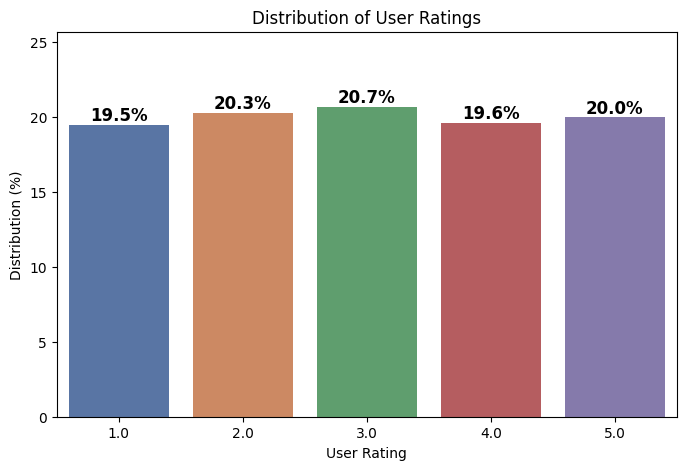

In [61]:
rating_counts = df_balanced["Rating"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index, palette="deep", legend=False)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.xlabel("User Rating")
plt.ylabel("Distribution (%)")
plt.title("Distribution of User Ratings")
plt.ylim(0, max(rating_counts.values) + 5)

plt.savefig("../images/user_rating_distribution.png", dpi=300, facecolor="white", bbox_inches="tight", transparent=True)

plt.show()

# **Step 4: Train Model**

In [62]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_balanced[["UserID", "BookID", "Rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [64]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

# Mở rộng phạm vi tìm kiếm tham số
param_grid = {
    "n_factors": [50, 100, 150, 200],
    "n_epochs": [20, 30, 40],
    "lr_all": [0.001, 0.002, 0.005, 0.01],
    "reg_all": [0.01, 0.02, 0.05, 0.1]
}

# Chạy Grid Search với 5-fold cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=5, n_jobs=-1)
grid_search.fit(data)

# Hiển thị kết quả tối ưu
print("Best RMSE:", grid_search.best_score["rmse"])
print("Best Params:", grid_search.best_params["rmse"])

Best RMSE: 1.157280227840627
Best Params: {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.05}


In [66]:
model = SVD(n_factors=20, n_epochs=30, lr_all=0.005, reg_all=0.02, random_state=42)

model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)

RMSE: 1.1907


# **Step 5: Recommend Book**

In [ ]:
def recommend_books(user_id, model, df, n=5):
    # Lấy danh sách tất cả sách
    all_books = df["BookID"].unique()
    
    # Lọc ra những sách mà user chưa đánh giá
    rated_books = df[df["UserID"] == user_id]["BookID"].values
    books_to_predict = [book for book in all_books if book not in rated_books]
    
    # Dự đoán rating cho từng sách chưa đọc
    predictions = [model.predict(user_id, book) for book in books_to_predict]
    
    # Sắp xếp theo rating dự đoán giảm dần
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Lấy top n sách gợi ý
    recommended_books = [pred.iid for pred in predictions[:n]]
    
    return recommended_books

In [ ]:
user_id = "A1L43KWWR05PCS"  # Chọn một UserID có trong dataset
recommended_books = recommend_books(user_id, model, df_balanced)

print(f"Top 5 sách gợi ý cho user {user_id}: {recommended_books}")

Top 5 sách gợi ý cho user A1L43KWWR05PCS: [126554, 121131, 103929, 108581, 125024]
